In [12]:
import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

In [13]:
def load(f, label):
    image = tf.io.read_file(f)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    
    return image, label

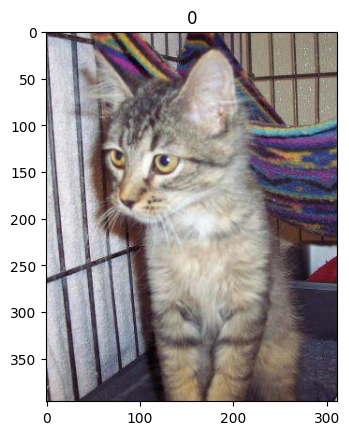

In [14]:
image, label = load('training_set/cats/cat.2.jpg',0)

fig, ax = plt.subplots()
ax.imshow(image/255.)
ax.set_title(label)
plt.show()

In [15]:
def resize(input_image, size):
    return tf.image.resize(input_image,size)

In [16]:
def random_crop(input_image):
    return tf.image.random_crop(input_image,size=[150,150,3])

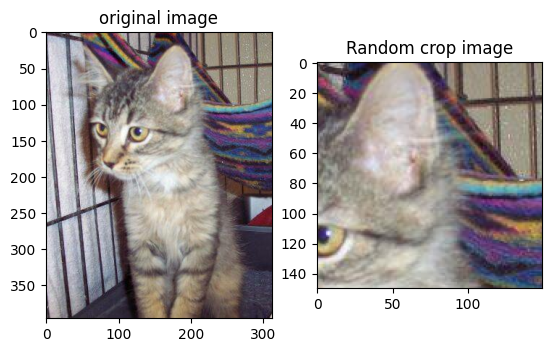

In [17]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image / 255.)
ax[0].set_title("original image")

ax[1].imshow(random_crop(image)/255.)
ax[1].set_title("Random crop image")

plt.show()

In [18]:
def central_crop(input_image):
    image = resize(input_image,[176,176])
    return tf.image.central_crop(image,central_fraction=0.84)

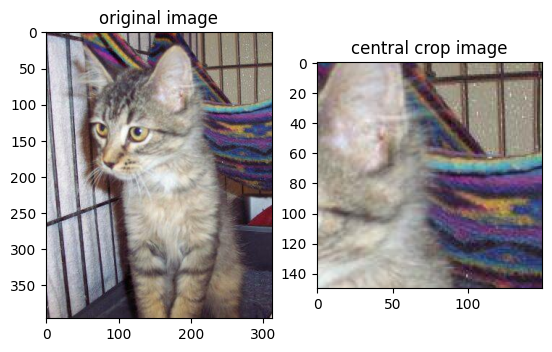

In [19]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image/ 255.)
ax[0].set_title("original image")

ax[1].imshow(random_crop(image) /255.)
ax[1].set_title("central crop image")
plt.show()

In [20]:
def random_rotation(input_image):
    angles = np.random.randint(0,3,1)
    return tf.image.rot90(input_image, k= angles[0])

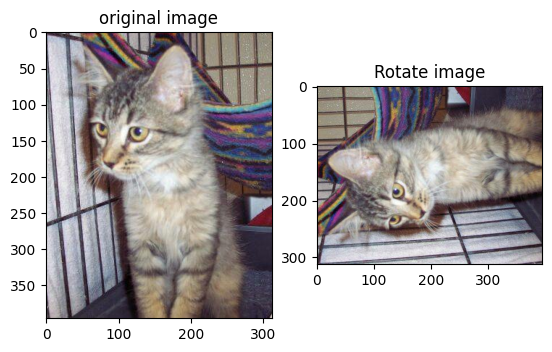

In [21]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image/255.)
ax[0].set_title("original image")

ax[1].imshow(random_rotation(image)/255.)
ax[1].set_title("Rotate image")
plt.show()

In [22]:
def random_jitter(input_image):
    image = resize(input_image, [176,176])
    image = random_crop(image)
    image = random_rotation(image)
    image = tf.image.random_flip_left_right(image)
    return image

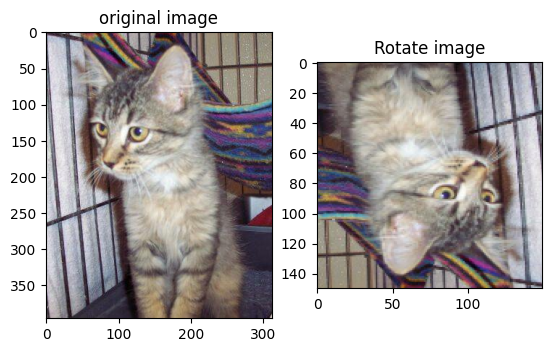

In [23]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image/255.)
ax[0].set_title("original image")

ax[1].imshow(random_jitter(image)/255.)
ax[1].set_title("Rotate image")
plt.show()

In [24]:
def normalize(input_image):
    mid = (tf.reduce_max(input_image) + tf.reduce_min(input_image))
    input_image = input_image / mid - 1
    return input_image

In [25]:
def load_image_train(image_file, label):
    image,label = load(image_file, label)
    image = random_jitter(image)
    image = normalize(image)
    return image,label

def load_image_val(image_file, label):
    image, label = load(image_file, label)
    image = central_crop(image)
    image = normalize(image)
    return image, label

In [26]:
temp_ds = tf.data.Dataset.list_files(os.path.join('training_set/cats','*.jpg'))
print(temp_ds)
temp_ds = temp_ds.map(lambda x: (x,0))

temp2_ds = tf.data.Dataset.list_files(os.path.join('training_set/dogs','*.jpg'))
temp2_ds = temp2_ds.map(lambda x: (x,1))

train_ds = temp_ds.concatenate(temp2_ds)

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [27]:
buffer_size = tf.data.experimental.cardinality(train_ds).numpy()
train_ds = train_ds.shuffle(buffer_size).map(load_image_train,num_parallel_calls = 16).batch(20).repeat()

In [28]:
temp_ds = tf.data.Dataset.list_files(os.path.join('test_set/cats','*.jpg'))
temp_ds = temp_ds.map(lambda x: (x,0))

temp2_ds = tf.data.Dataset.list_files(os.path.join('training_set/dogs','*.jpg'))
temp2_ds = temp2_ds.map(lambda x: (x,1))

test_ds = temp_ds.concatenate(temp2_ds)

test_ds = test_ds.map(load_image_val,num_parallel_calls=16).shuffle(buffer_size).batch(20).repeat()

<>:5: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:5: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_769413/1860251069.py:5: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if np.amax(image) is not 0:
2024-05-29 17:05:18.205571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4000]
	 [[{{node Placeholder/_0}}]]
2024-05-29 17:05:18.206518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype string and shape [4005]
	 [[{{node Placeholder/_8}}]]
/tmp/ipykernel_769413/1860251069.py:6: RuntimeWarning:

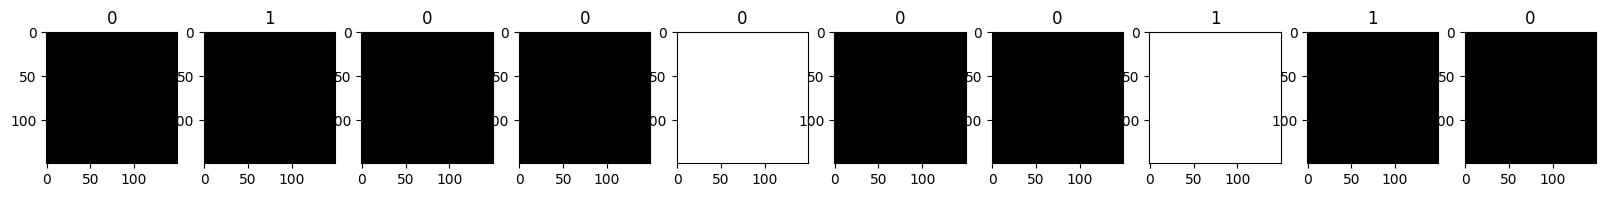

In [29]:
for images, labels in train_ds.take(1):
    fig, ax = plt.subplots(1,10,figsize=(20,6))
    for j in range(10):
        image = images[j].numpy()
        if np.amax(image) is not 0:
            image = image / np.amax(image)
            image = np.clip(image, 0 ,1)
            ax[j].imshow(image)
            ax[j].set_title(labels[j].numpy())
plt.show()

In [31]:
import tensorflow as tf

class Conv(tf.keras.layers.Layer):  # Inherit from tf.keras.layers.Layer
    def __init__(self, filters, kernel_size):
        super(Conv, self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        
    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = self.relu(x)
        x = self.pool(x)
        return x

# Example input image batch
image = tf.random.uniform((1, 150, 150, 3))  # Example image with shape (batch_size, height, width, channels)

# Build the model using the custom Conv layer
model = tf.keras.Sequential(name='image_preprocessing')
model.add(Conv(filters=32, kernel_size=(3,3)))
model.add(Conv(filters=64, kernel_size=(3,3)))
model.add(Conv(filters=128, kernel_size=(3,3)))
model.add(Conv(filters=128, kernel_size=(3,3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax))

# Call the model with an example image
output = model(image[:1])
print(output)



tf.Tensor([[0.20560534 0.79439473]], shape=(1, 2), dtype=float32)


In [32]:
# checkpoint_path = "./train/cat_dog_cnn/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_best_only=True,
#                                                  save_weights_only=True,
#                                                  verbose=1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "image_preprocessing"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_4 (Conv)               (1, 74, 74, 32)           1024      
                                                                 
 conv_5 (Conv)               (1, 36, 36, 64)           18752     
                                                                 
 conv_6 (Conv)               (1, 17, 17, 128)          74368     
                                                                 
 conv_7 (Conv)               (1, 7, 7, 128)            148096    
                                                                 
 flatten_1 (Flatten)         (1, 6272)                 0         
                                                                 
 dense_2 (Dense)             (1, 512)                  3211776   
                                                                 
 dense_3 (Dense)             (1, 2)            

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint
from glob import glob
import os


train_len = len(glob(os.path.join('training_set/cats', '*.jpg'))) * 2
test_len = len(glob(os.path.join('test_set/cats', '*.jpg'))) * 2

checkpoint_path = "model_checkpoint.h5"
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, verbose=1)

# Fit the model
model.fit(
    train_ds,
    steps_per_epoch=train_len // 32,  # Adjust batch size if necessary
    epochs=30,
    callbacks=[cp_callback],
    validation_data=test_ds,
    validation_steps=test_len // 32  # Adjust batch size if necessary
)

Epoch 1/30


2024-05-29 17:05:28.896402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype string and shape [4005]
	 [[{{node Placeholder/_8}}]]
2024-05-29 17:05:28.897160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype string and shape [4005]
	 [[{{node Placeholder/_8}}]]


250/250 [==============================] - ETA: 0s - loss: 0.7218 - accuracy: 0.6356

2024-05-29 17:08:31.389967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1011]
	 [[{{node Placeholder/_0}}]]
2024-05-29 17:08:31.390344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype string and shape [4005]
	 [[{{node Placeholder/_8}}]]



Epoch 1: val_loss improved from inf to 1.32035, saving model to model_checkpoint.h5
250/250 [==============================] - 195s 772ms/step - loss: 0.7218 - accuracy: 0.6356 - val_loss: 1.3203 - val_accuracy: 0.1865
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.5730 - accuracy: 0.7067
Epoch 2: val_loss improved from 1.32035 to 0.68913, saving model to model_checkpoint.h5
250/250 [==============================] - 192s 768ms/step - loss: 0.5730 - accuracy: 0.7067 - val_loss: 0.6891 - val_accuracy: 0.5889
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.7164
Epoch 3: val_loss improved from 0.68913 to 0.65880, saving model to model_checkpoint.h5
250/250 [==============================] - 197s 787ms/step - loss: 0.5503 - accuracy: 0.7164 - val_loss: 0.6588 - val_accuracy: 0.6254
Epoch 4/30
250/250 [==============================] - ETA: 0s - loss: 0.5055 - accuracy: 0.7541
Epoch 4: val_loss did not improve from 0.65880

In [34]:
model.evaluate(test_ds, steps = test_len // 32)

63/63 [==============================] - 15s 145ms/step - loss: 0.5681 - accuracy: 0.7762


[0.5680958032608032, 0.776190459728241]

In [41]:

checkpoint_path = "model_checkpoint.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, verbose=1)




In [43]:
model_inf = tf.keras.Sequential(name='Cat_Dog_CNN_load')

model_inf.add(Conv(filters=32, kernel_size=(3, 3)))
model_inf.add(Conv(filters=64, kernel_size=(3, 3)))
model_inf.add(Conv(filters=128, kernel_size=(3, 3)))
model_inf.add(Conv(filters=128, kernel_size=(3, 3)))

model_inf.add(tf.keras.layers.Flatten())  
model_inf.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu)) 
model_inf.add(tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax))  

model_inf.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics = ['accuracy'])

for images, labels in train_ds.take(1):
    outputs = model_inf(images, training=False)
    

2024-05-30 10:15:01.273613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4000]
	 [[{{node Placeholder/_0}}]]
2024-05-30 10:15:01.274020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype string and shape [4005]
	 [[{{node Placeholder/_8}}]]


2024-05-30 10:30:50.278748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype string and shape [4005]
	 [[{{node Placeholder/_8}}]]
2024-05-30 10:30:50.281091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1011]
	 [[{{node Placeholder/_0}}]]


Image 0: Predicted raw output: [0.00211228 0.9978877 ], True label: 0
Image 1: Predicted raw output: [0.05279534 0.9472046 ], True label: 1
Image 2: Predicted raw output: [0.00436854 0.9956314 ], True label: 1
Image 3: Predicted raw output: [0.01516982 0.9848302 ], True label: 0
Image 4: Predicted raw output: [0.11890166 0.8810984 ], True label: 0
Image 5: Predicted raw output: [0.01154051 0.98845947], True label: 0
Image 6: Predicted raw output: [0.01441025 0.98558974], True label: 0
Image 7: Predicted raw output: [0.02088013 0.9791199 ], True label: 1
Image 8: Predicted raw output: [0.04012964 0.9598703 ], True label: 1
Image 9: Predicted raw output: [0.03607352 0.9639265 ], True label: 1
Image 10: Predicted raw output: [0.00467218 0.9953279 ], True label: 1
Image 11: Predicted raw output: [0.00116361 0.99883646], True label: 1
Image 12: Predicted raw output: [0.01233974 0.98766017], True label: 1
Image 13: Predicted raw output: [0.00532493 0.994675  ], True label: 1
Image 14: Predic

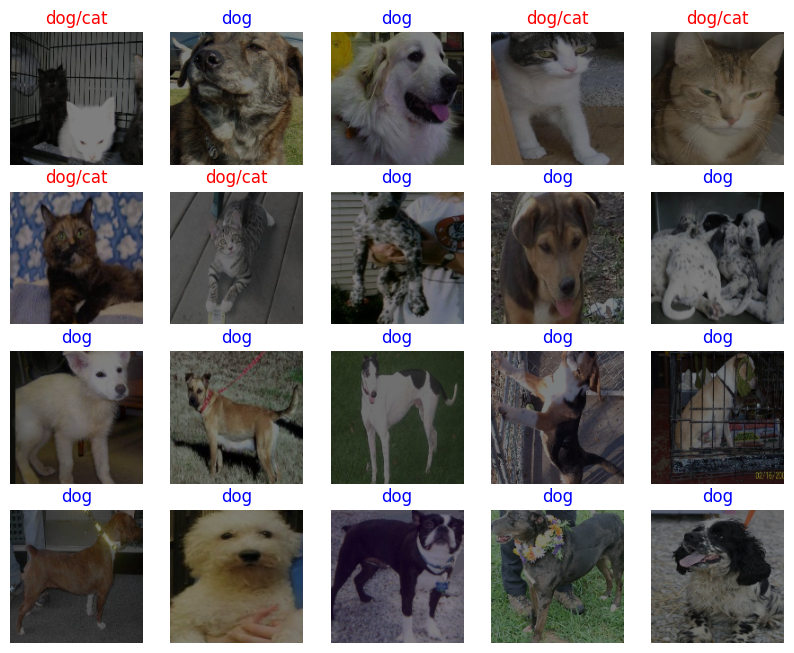

In [54]:
test_batch_size = 25

# Take one batch of images and labels from the test dataset
for images, labels in test_ds.take(1):
    predictions = model_inf(images)

# Limit to the specified test batch size
images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

# Mapping of class indices to labels
labels_map = {0: 'cat', 1: 'dog'}

# Print raw predictions for debugging
for i, (pred, label) in enumerate(zip(predictions, labels)):
    print(f"Image {i}: Predicted raw output: {pred.numpy()}, True label: {label.numpy()}")

# Create a figure for displaying the images and predictions
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)

    # Convert prediction to class index
    predicted_class = np.argmax(y_pred.numpy())
    true_class = py.numpy()

    # Determine title and color based on prediction accuracy
    if predicted_class == true_class:
        title = "{}".format(labels_map[true_class])
        color = 'blue'
    else:
        title = "{}/{}".format(labels_map[predicted_class], labels_map[true_class])
        color = 'red'
    
    # Display the image with the corresponding title
    p.set_title(title, color=color)
    p.imshow(px.numpy() * 0.5 + 0.5)
    p.axis('off')

plt.show()